<a href="https://colab.research.google.com/github/BrainConnection/QuTiP/blob/main/Project%20Dynamic%20Decoupling/Noise%20Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setting

In [ ]:
!pip install qutip
!pip install numpy
!pip install matplotlib
!pip install scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 44.3 MB/s eta 0:00:00


In [ ]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate

/usr/local/lib/python3.10/dist-packages/qutip/__init__.py:65: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


#1. X Pulse Drive

###1) Hamiltonian without Resonator Coupling

$H = -\frac{\omega_q}{2}\sigma_z + A\sigma_x\cos{(\omega_{rot} t)} $

In [ ]:
# Basic parameters

omega_q = 2 * np.pi * 6.0  # resonator frequency in units of GHz
omega_rot = 2 * np.pi * 3.0  # qubit frequency in units of GHz

# kappa = 2 * np.pi * 0.01   # external coupling rate of resonator in units of GHz
#tau = 200 # readout pulse length in units of ns

tlist = np.linspace(0, 100, 1000)

In [ ]:
# operator
sz = sigmaz()
sx = sigmax()
sy = sigmay()

H0 = -0.5*omega_q*sz

op_list = [sx, sy, sz]

In [ ]:
# time-dependent coefficient for drive
def Hrd_env(t, args):
    """
    Envelope function for the readout drive
    """
    A = args['A'] # amplitude of the readout drive
    T = args['T'] # duration of the readout drive, in units of ns

    return A * (0 <= t) * (t <= T)

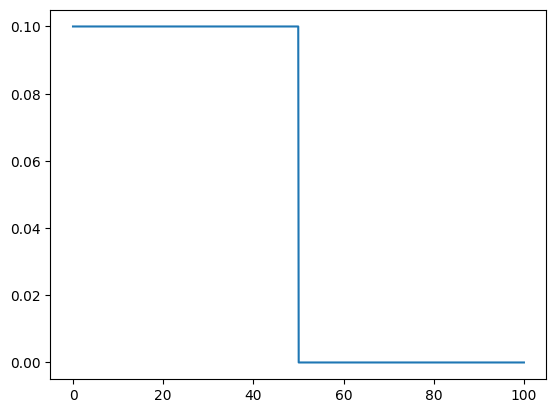

In [ ]:
# list of times for numerical simulation (in units of ns)
plt.figure()
plt.plot(tlist, Hrd_env(tlist, {'A': 0.1, 'T': 50, 'omega_rot': omega_rot}))

In [ ]:
result0 = mesolve(
    [sx, Hrd_env],
    basis(2,0),
    tlist,
    args = {'A': 0.1*np.pi, 'T': 5, 'omega_rot': omega_rot},
    e_ops = op_list,
    options = Options(nsteps = 1000000, atol = 1e-10, rtol = 1e-8)
)

Text(0, 0.5, 'Expectation Value')

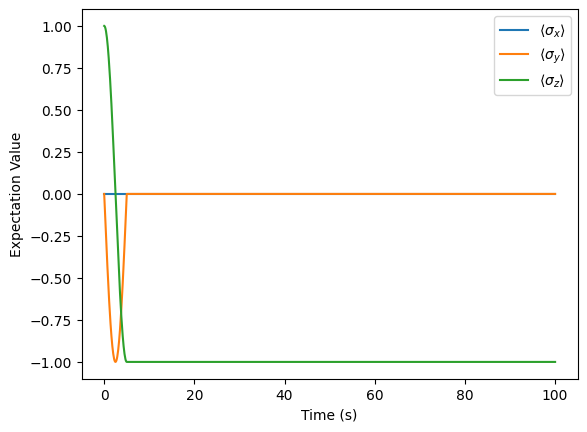

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result0.expect[0], label = r'$\langle\sigma_x\rangle$')
ax.plot(tlist, result0.expect[1], label = r'$\langle\sigma_y\rangle$')
ax.plot(tlist, result0.expect[2], label = r'$\langle\sigma_z\rangle$')
ax.legend(loc = 0)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Expectation Value')

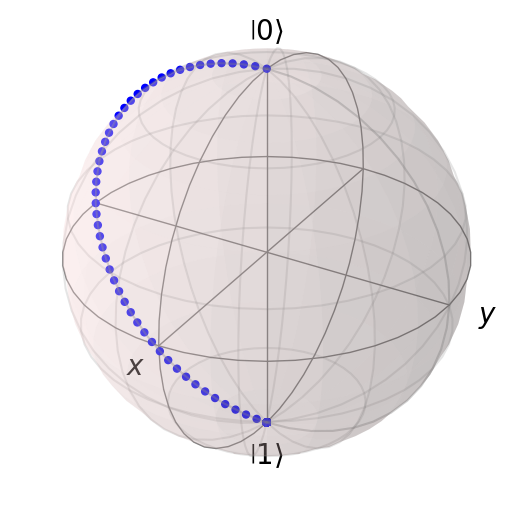

In [ ]:
# Create Bloch sphere plot
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result0.expect, meth="s")
sphere.show()

#2. Play with Noise

### 1) Auto Correlation

In [ ]:
tlist = np.linspace(-10, 10, 1000)

omega_0 = 2*np.pi*0.2

u_1 = np.sin(omega_0*tlist + np.pi/4)

Text(0, 0.5, 'Expectation Value')

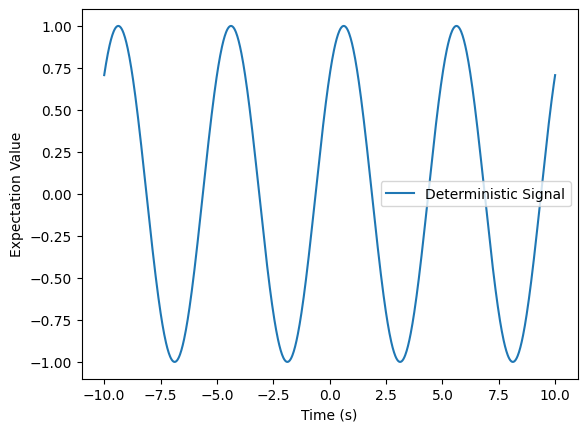

In [ ]:
# Deterministic Function

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, u_1, label = 'Deterministic Signal')
ax.legend(loc = 0)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Expectation Value')

In [ ]:
tau_list = np.linspace(-5, 5, 100)

def Gamma(tau):

    lst = []
    for i in range(100):
      u_1 = np.sin(omega_0*tlist + np.pi/4)
      u_1_ = np.sin(omega_0*tlist + omega_0*tau[i] + np.pi/4)
      u_mult = u_1 * u_1_

      n = 0
      for j in range(1000):
        n = n + u_mult[j]

      lst.append(n/1000)

    return np.array(lst)

Text(0, 0.5, 'Expectation Value')

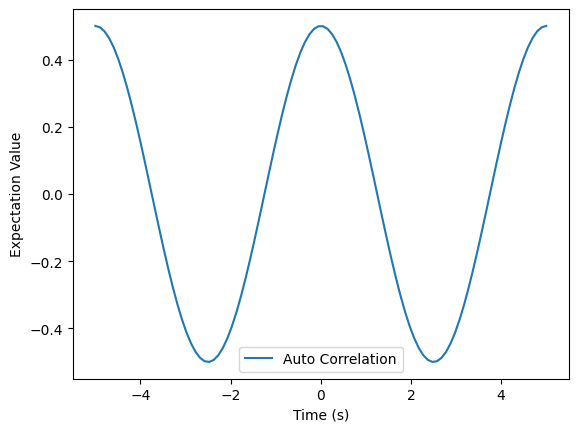

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.plot(tau_list, Gamma(tau_list), label = 'Auto Correlation')
ax.legend(loc = 0)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Auto Correlation')

Text(0, 0.5, 'Spectral Density')

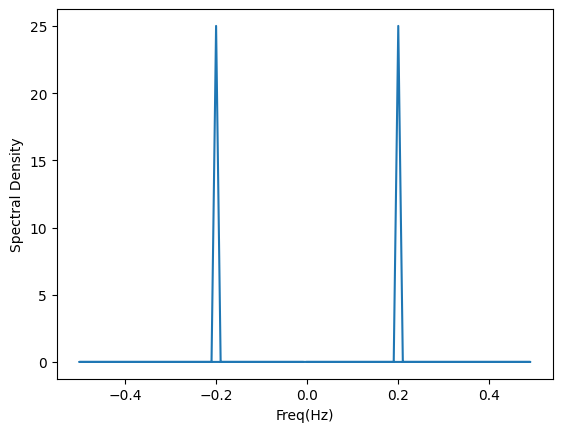

In [ ]:
Gamma_fft = np.fft.fft(Gamma(tau_list))
Gamma_freq = np.fft.fftfreq(len(Gamma(tau_list)), d=tau_list[1]-tau_list[0])

plt.figure()
plt.plot(Gamma_freq, np.abs(Gamma_fft))
#plt.xlim(0,0.1)
plt.xlabel('Freq(Hz)')
plt.ylabel('Spectral Density')

In [ ]:
# Shot Noise

mu, sigma = 0, 1 # mean and standard deviation
s = np.random.normal(mu, sigma, 1000)

lst = []
for i in range(1000):
  for j in range(10):
    lst.append(s[i])

arr = np.array(lst)

In [ ]:
gamma_list = []

for tau in range(-100, 100, 1):
  n = 0

  for i in range(1000, 9000, 1):
    n = n + arr[i]*arr[i+tau]

  gamma_list.append(n/8000)

gamma = np.array(gamma_list)
tau_list = np.array(range(-100, 100, 1))

Text(0, 0.5, 'Auto Correlation')

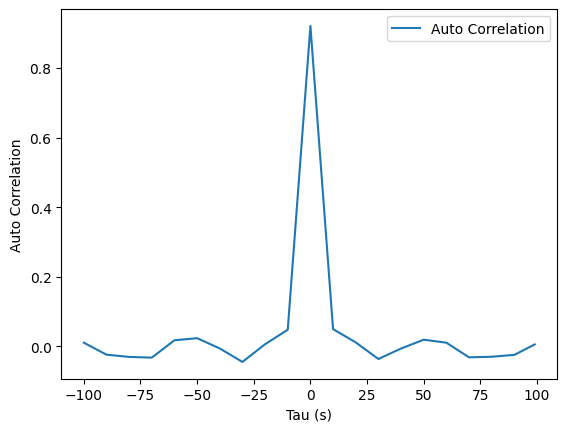

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.plot(tau_list, gamma, label = 'Auto Correlation')
ax.legend(loc = 0)
ax.set_xlabel('Tau (s)')
ax.set_ylabel('Auto Correlation')

Text(0, 0.5, 'Spectral Densitys Absolute Value')

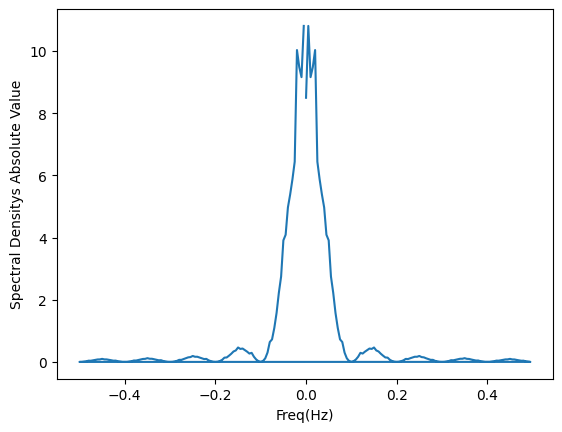

In [ ]:
Gamma_fft = np.fft.fft(gamma)
Gamma_freq = np.fft.fftfreq(len(gamma), d=tau_list[1]-tau_list[0])

plt.figure()
plt.plot(Gamma_freq, np.abs(Gamma_fft))
#plt.xlim(0,0.1)
plt.xlabel('Freq(Hz)')
plt.ylabel('Spectral Density''s Absolute Value')

In [ ]:
# Random Noise

mu, sigma = 0, 1 # mean and standard deviation
s = np.random.normal(mu, sigma, 10000)

arr = np.array(s)

In [ ]:
gamma_list = []

for tau in range(-100, 100, 1):
  n = 0

  for i in range(1000, 9000, 1):
    n = n + arr[i]*arr[i+tau]

  gamma_list.append(n/8000)

gamma = np.array(gamma_list)
tau_list = np.array(range(-100, 100, 1))

Text(0, 0.5, 'Auto Correlation')

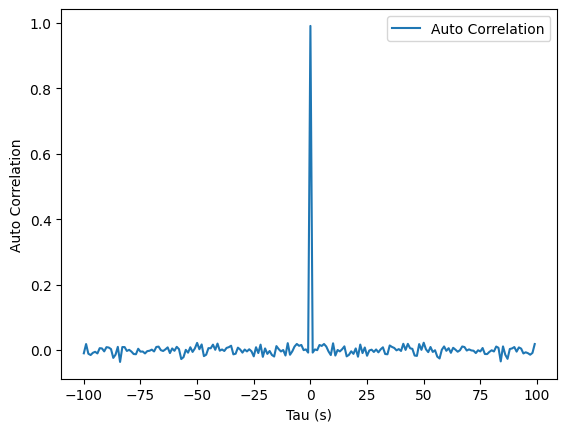

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.plot(tau_list, gamma, label = 'Auto Correlation')
ax.legend(loc = 0)
ax.set_xlabel('Tau (s)')
ax.set_ylabel('Auto Correlation')

Text(0, 0.5, 'Spectral Densitys Absolute Value')

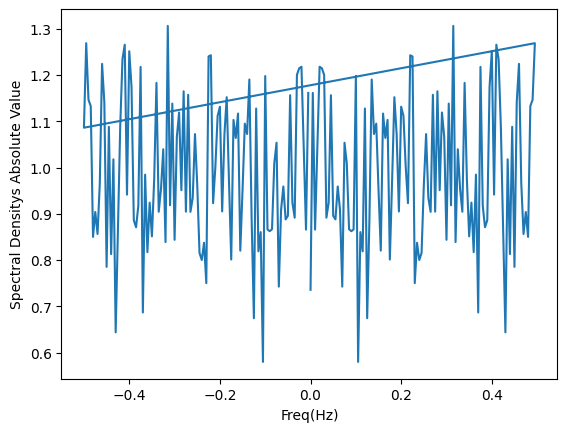

In [ ]:
Gamma_fft = np.fft.fft(gamma)
Gamma_freq = np.fft.fftfreq(len(gamma), d=tau_list[1]-tau_list[0])

plt.figure()
plt.plot(Gamma_freq, np.abs(Gamma_fft))
#plt.xlim(0,0.1)
plt.xlabel('Freq(Hz)')
plt.ylabel('Spectral Density''s Absolute Value')